In [146]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import random

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

# bibliografie: 
# https://blog.sicara.com/getting-started-genetic-algorithms-python-tutorial-81ffa1dd72f9
# https://www.tutorialspoint.com/genetic_algorithms/index.htm
# https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/

# Algoritmi genetici

Calculul maximului functiei $f: [3, 10] \times [4, 8] \rightarrow (0, \infty)$, unde functia este:

$$f(x, y) = sin\left(\pi \cdot 10 \cdot x + \frac{10}{1 + y^2}\right) + ln(x^2 + y^2)$$

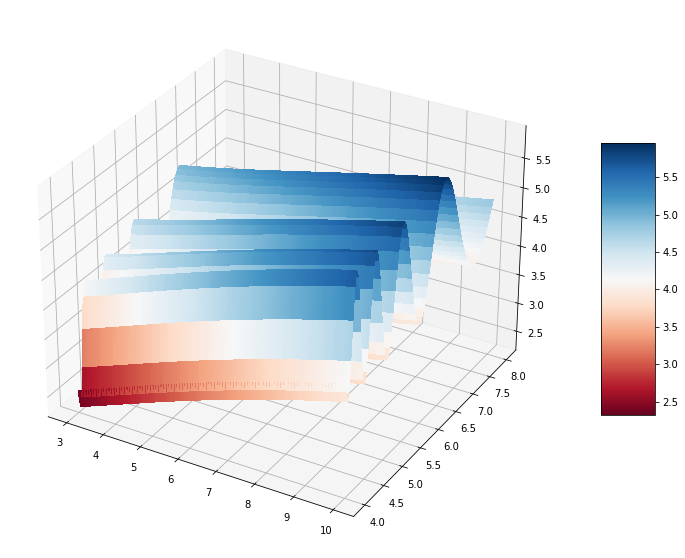

In [147]:
def f(x, y):
    return np.sin(np.pi * 20 * 10/(1 + y**2)) + np.log(x**2 + y**2)


# 100 de puncte pe fiecare directie
sampling = 100

# cream o esantionare de puncte cu numar de puncte dat, pentru fiecare coordonata
x = np.linspace(3, 10, num=sampling)
y = np.linspace(4, 8, num=sampling)

# se creeaza o grila de puncte pe fiecare dimensiune
X, Y = np.meshgrid(x, y)
Z = np.zeros((sampling, sampling))

# se calculeaza valoarea functiei in fiecare punct in acea grila
for i in range(sampling):
    for j in range(sampling):
        Z[i, j] = f(X[i, j], Y[i, j])
        
# crearea unei figuri si setarea dimensiunilor sale
fig = plt.figure()
fig.set_size_inches(18, 10)

# reprezentare 3D
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)

# adaugarea legendei si reprezentarea
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [148]:
def gen_population(n, k):
    population = []
    x_coord_values = [np.random.randint(0,2,k).tolist() for _ in range(n)]
    x_coord_values = [''.join([str(elem) for elem in value]) for value in x_coord_values]
    x_coord_values = ["0b"+value for value in x_coord_values]
    
    y_coord_values = [np.random.randint(0,2,k).tolist() for _ in range(n)]
    y_coord_values = [''.join([str(elem) for elem in value]) for value in y_coord_values]
    y_coord_values = ["0b"+value for value in y_coord_values]
    
    for x_val, y_val in zip(x_coord_values, y_coord_values):
        value ={"x": x_val, "y": y_val}
        population.append(value)
    return population
    


In [149]:
def x_c(v, a, b, k):
    """
    Convert the bit value of v to a value within the interval [a, b]
    """
    return a+(v*(b-a)/(pow(2,k)-1))

assert(x_c(0, 3, 10, 10) == 3)
assert(x_c((1 << 10) - 1, 3, 10, 10) == 10)
assert(x_c(0, 4, 8, 10) == 4)
assert(x_c((1 << 10) - 1, 4, 8, 10) == 8)

In [150]:
def convert_to_interval(population,k):
    interval_pop = []
    for value in population:
        x_coord_val = x_c(int(value["x"],2),3,10,k)
        y_coord_val = x_c(int(value["y"],2),4,8,k)
        value ={"x": x_coord_val, "y": y_coord_val}
        interval_pop.append(value)
    return interval_pop

In [151]:
def selection(population, k):
    """
    Functia de selectie primeste populatia de cromozomi, impreuna cu k, lungimea unui cromozom,
    si creeaza o noua generatie
    
    Va intoarce noua generatie de cromzomi
    """
    pop_interval = convert_to_interval(population,k)

    function_values = [f(value["x"], value["y"]) for value in pop_interval]
    function_sum = sum(function_values)
    
    p = [value/function_sum for value in function_values]

    q = []
    
    q.append(p[0])
    for j in range(2,len(p)+1):
        probability_sum = 0
        for i in range (0, j):
            probability_sum +=  p[i]
        q.append(probability_sum)

    numbers = np.random.uniform(0,1,len(q))
    selected_pop = []

    for index in range(len(numbers)):
        if numbers[index]>0 and numbers[index]<=q[0]:
            selected_pop.append(population[0])
        for index2 in range(0, len(q)-1):
            if numbers[index]>q[index2] and numbers[index]<=q[index2+1]:
                selected_pop.append(population[index2+1])     
    return selected_pop

In [152]:
def crossover_chr(a, b, t, k):
    """
    Procedura de crossover va genera alti doi cromozomi in care primii t biti din a si b
    vor fi inversati intre cromozomi.
    """
    list_a = [elem for elem in a]
    list_b = [elem for elem in b]
    for index in range(len(a)-1, len(a)-t-2, -1):
        aux = list_a[index]
        list_a[index] = list_b[index]
        list_b[index] = aux    
    return ''.join(list_a), ''.join(list_b)

# daca lucrati pe biti, asta ar trebui sa rezulte
#aici am este un bug daca lasam fara sa fie string, pentru ca la variabila b, nu ne-ar lua in considerare intreg numarul
# deoarece incepe cu 0
a = "0b1111100011"
b = "0b0100111100"
a, b = crossover_chr(a, b, 4, 10)
assert(a == "0b1111111100")
assert(b == "0b0100100011")

In [153]:
def crossover(population, k, pc = 0.1):
    """
    Selecteaza cativa cromozomi din populatie si face cross-over intre ei, pe perechi
    k este numarul de biti din cromozom iar pc probabilitatea de cross-over
    """
    numbers = np.random.uniform(0,1,len(population))
    choosen_cromosome = []
    for index in range(len(numbers)):
        if numbers[index]<pc:
            choosen_cromosome.append(population[index])
    if len(choosen_cromosome)%2==1:
        choosen_cromosome.pop()
    for index in range(0, len(choosen_cromosome),2):
        t = random.randint(1,k)
        first_cromosome_x = population[index]["x"]
        second_cromosome_x = population[index+1]["x"]
        first_cromosome_y = population[index]["y"]
        second_cromosome_y = population[index+1]["y"]
        chr1_x, chr2_x = crossover_chr(first_cromosome_x, second_cromosome_x, t, k)
        chr1_y, chr2_y = crossover_chr(first_cromosome_y, second_cromosome_y, t, k)
        chr1 = {"x": chr1_x, "y": chr1_y}
        chr2 = {"x": chr2_x, "y": chr2_y}
        population[index] = chr1
        population[index+1] = chr2
    return population

In [154]:
def mutate_chr(a, t, k):
    """
    Procedura de mutatie va reseta/seta un bit din cromozom
    a este cromozomul reprezentat in binar
    t este pozitia ce se schimba
    k este numarul de biti din cromozom
    """
    bits = [elem for elem in a]
    bits[len(bits)-t-1] = "1" if bits[len(bits)-t-1] == "0" else "0"
    return ''.join(bits)

# daca lucrati pe biti, assert-urile trebuie sa treaca
# daca lucrati cu liste de biti, scrieti assert-urile corespunzatoare
assert(mutate_chr("0b1111000011", 6, 10) == "0b1110000011")
assert(mutate_chr("0b1111000011", 7, 10) == "0b1101000011")
assert(mutate_chr("0b1111000011", 0, 10) == "0b1111000010")

In [155]:
# mutation
def mutation(population, k, pm = 0.01):
    """
    Procedura de mutation va seta/reseta un bit dintr-un cromozom
    population este lista de cromozomi
    k este numarul de biti din cromozom
    pm este probabilitatea mutatiei
    """
    for index in range(0, len(population)):
        numbers = np.random.uniform(0,1,k)
        for index2 in range(len(numbers)):
            if(numbers[index2]<pm):
                x_value = mutate_chr(population[index]["x"],index2, k)
                y_value = mutate_chr(population[index]["y"],index2, k)
                value = {"x": x_value, "y": y_value}
                population[index] = value
    return population

In [156]:
def compute_average(population, k):
    """
    Calculeaza media valorii functiei obiectiv pentru populatia data
    """
    population_in_interval = convert_to_interval(population,k)
    return sum([f(value["x"], value["y"]) for value in population_in_interval])/len(population_in_interval)

def maximum(population, k):
    """
    Calculeaza maximul valorii functiei obiectiv pentru populatia data
    """
    population_in_interval = convert_to_interval(population,k)
    return max([f(value["x"], value["y"]) for value in population_in_interval])

In [157]:
def write_population(file, population):
    """
    Scrie populatia in fisierul text deschis anterior (atentie la conversia \r\n, daca e cazul)
    """
    for item in population:
        file.write(str(item["x"]) + ' ' + str(item["y"]))
        file.write('\n')

In [158]:
# crearea populatiei initiale, 20 de biti per cromozom
k = 20

# creeaza populatia, random
population = gen_population(10, k)

# deschide fisierul de iesire
file = open("output.txt", "w")

# selection
population = selection(population, k)
n = len(population)
for i in range(n):
    # scrie antetul populatiei, "#numar generatie: .."
    file.write("#numar generatie: " + str(i) + '\n')
    
    # scrie populatia
    write_population(file, population)
    
    # tipareste pe ecran media populatiei si maximul
    # pe parcursul generatiilor, media populatiei trebie sa fie monoton crescatoare
    print("medie: ", compute_average(population, k), "maxim: ", maximum(population,k))
    
    # apeleaza, in ordine, selection, crossover si mutation
    population = selection(population, k)
    population = crossover(population, k)
    population = mutation(population, k)
    
    

# scrie media si maximul ultimei iteratii
print(compute_average(population, k))
print(maximum(population, k))

# la fel pentru fisier
file.write(str(compute_average(population, k)))
file.write('\n')
file.write(str(maximum(population, k)))
file.write('\n')

# scrie "#sfarsit" si inchide fisierul
file.write("sfarsit")
file.close()

medie:  5.191269670390438 maxim:  5.731857977364936
medie:  5.312211689642059 maxim:  5.731893632669295
medie:  5.286409781169623 maxim:  5.731960043941145
medie:  5.576088415044442 maxim:  5.735097726053632
medie:  5.565570340252128 maxim:  5.756345283152252
medie:  5.563767267938061 maxim:  5.735097726053632
medie:  5.380277913176269 maxim:  5.735097726053632
medie:  5.254527595417908 maxim:  5.732673022915187
medie:  5.298304978816265 maxim:  5.732673022915187
medie:  5.427746275189197 maxim:  5.732673022915187
5.353219480265629
5.817037441920809
